Notebook for analysis and feature engineering on named features - amount and time
* 'Amount' : Transaction Amount
* 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset

In [1]:
import pandas as pd 
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/raw/creditcard.csv')

In [3]:
# hour within a day cycle
df['Hour'] = (df['Time'] // 3600) % 24

# hour is cyclical, so we use sine and cosine transformations
# to represent the cyclical nature of hours in a day
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)

# day
df['Day'] = df['Time'] // (3600*24)

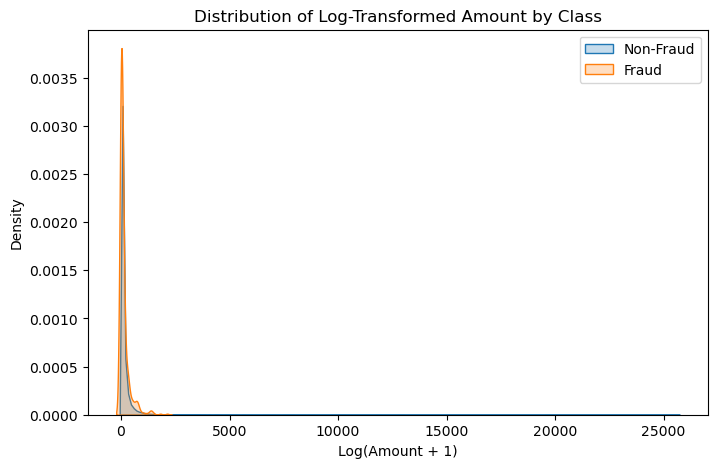

In [4]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df['Class']==0]['Amount'], label='Non-Fraud', fill=True)
sns.kdeplot(df[df['Class']==1]['Amount'], label='Fraud', fill=True)
plt.title('Distribution of Log-Transformed Amount by Class')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [5]:
# values are skewed, apply log transform 
df['log_Amount'] = np.log(df['Amount']+ 1e-6)  # avoid zero log issue

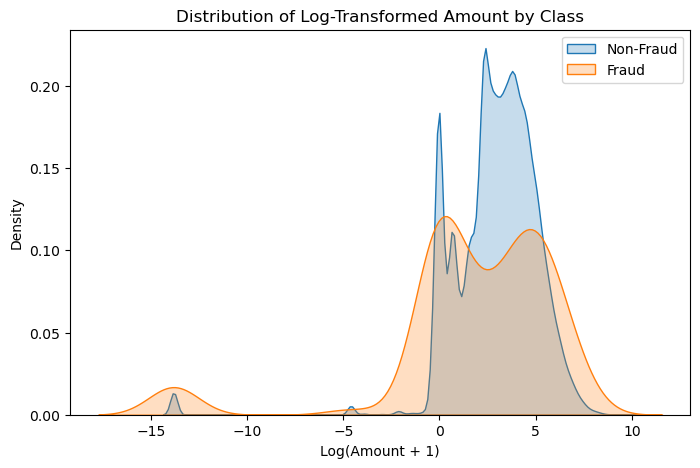

In [6]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df['Class']==0]['log_Amount'], label='Non-Fraud', fill=True)
sns.kdeplot(df[df['Class']==1]['log_Amount'], label='Fraud', fill=True)
plt.title('Distribution of Log-Transformed Amount by Class')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

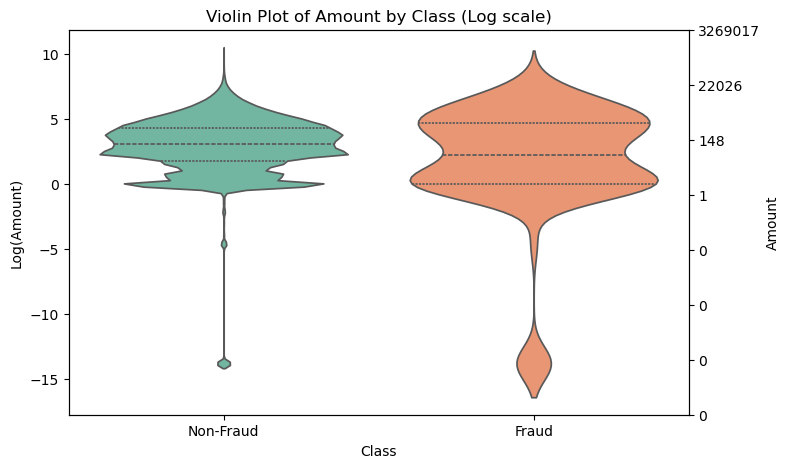

In [7]:
fig, ax1 = plt.subplots(figsize=(8,5))

sns.violinplot(x='Class', y='log_Amount', data=df, ax=ax1, inner='quartile', palette='Set2')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Non-Fraud', 'Fraud'])
ax1.set_xlabel('Class')
ax1.set_ylabel('Log(Amount)')
ax1.set_title('Violin Plot of Amount by Class (Log scale)')

ax2 = ax1.twinx()
yticks = ax1.get_yticks()
ax2.set_yticks(yticks)
ax2.set_yticklabels([f"{int(np.exp(y))}" for y in yticks])
ax2.set_ylabel('Amount')

plt.show()

In [8]:
# Engineer more features from 'Time'
# 0-6: Night, 6-12: Morning, 12-18: Afternoon, 18-24: Evening
df['Time_bin'] = pd.cut(df['Hour'], bins=[0,6,12,18,24],
                        labels=['Night','Morning','Afternoon','Evening'],
                        right=False)

# Feature by amount bins 
# 3 bins by quantile of amount: Low, Medium, High
df['Amount_bin'] = pd.qcut(df['Amount'], q=3, labels=['Low','Medium','High'])


In [9]:
print(df.groupby('Time_bin')['Class'].mean().sort_values(ascending=False))

print(df.groupby('Amount_bin')['Class'].mean().sort_values(ascending=False))

Time_bin
Night        0.005181
Morning      0.001664
Afternoon    0.001390
Evening      0.001240
Name: Class, dtype: float64
Amount_bin
Low       0.002559
High      0.001984
Medium    0.000608
Name: Class, dtype: float64


In [10]:
"""
night - 0, mor - 1, afternoon - 2, eve - 3
low - 0, med - 1, high - 2
"""
df['Time_bin'] = df['Time_bin'].cat.codes
df['Amount_bin'] = df['Amount_bin'].cat.codes

In [12]:
df.to_csv('../data/processed/creditcard_fe.csv', index=False)